<a href="https://colab.research.google.com/github/denizmsayin/singan/blob/master/run.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import subprocess as sp
from time import time

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

from models import *
from utils import *

## Notes
- Every generator and critic at every scale has the same architecture, with 5 Conv(3x3)-BN-LReLU layers.
- The patch size is given as 11x11, which comes from the receptive field of the 5 layer deep network.
- How the number of kernels change is not exactly clear, paper says "start with 32, double once every 4 scales"
- It is not clear whether the conv layers use padding (zero, reflect?) to preserve size or not. We assume for now that the generators do preserve the size, but it does not seem necessary for the critics.
- How the downsampling is done is not clear from the paper. We assume bicubic interpolation.
- For the coarsest scale, authors say that "the effective receptive field at this level is typically∼1/2of the image’s height". ~~We assume that this means the input size at the coarsest scale is somewhere between 20 and 25 pixels.~~ The authors later state that they use 25 px for the coarsest and 250 pixels for the finest scale along with a rescaling ratio of 4/3. 
- Lots of training details are given in the supplementary material.
- It is not clear 

In [2]:
def prepare_bsds300():
  if os.path.isdir('BSDS300'):
    print('Dataset already downloaded')
  else:
    sp.call(('wget', 'https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/BSDS300-images.tgz'))
    sp.call(('tar', '-xzf', 'BSDS300-images.tgz'))
    sp.call(('rm', '-f', 'BSDS300-images.tgz'))
    print('Downloaded dataset successfully')

In [3]:
# as given in the paper
LEARNING_RATE = 0.0005
BETA_1 = 0.5
BETA_2 = 0.999
NUM_ITERS = 2000
LR_DROP_STEP = 1600
LR_DROP_MULT = 0.1
GEN_STEP_PER_ITER = 3
DIS_STEP_PER_ITER = 3
REC_ALPHA = 10.0
GP_WEIGHT = 0.1 # paper: 0.1
NUM_SCALES = 1
SCALING_FACTOR = 4/3
INITIAL_KERNEL_COUNT = 32
INCREASE_KERNEL_COUNT_EVERY = 4 # SCALES
NOISE_BASE_STD = 0.1
FIRST_SCALE_NOISE_STD = 1.0
START_SIZE = (25, 25)

def conv2d_initializer(conv2d):
    pass
    torch.nn.init.normal_(conv2d.weight, 0.0, 0.02)
    torch.nn.init.constant_(conv2d.bias, 0.0)

def batch_norm_initializer(bn):
    pass
    torch.nn.init.normal_(bn.weight, 1.0, 0.02)
    torch.nn.init.constant_(bn.bias, 0.0)


PRINT_EVERY = 25
DEVICE = 'cuda'
SEED = 796

Dataset already downloaded
BSDS300/images/train/109034.jpg


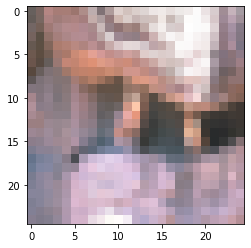

In [4]:
prepare_bsds300()

DS_DIR = 'BSDS300/images/train'
EXAMPLE_IDX = 11
IMG_LIST = sorted(os.listdir(DS_DIR))
EXAMPLE_IMG_PATH = os.path.join(DS_DIR, IMG_LIST[EXAMPLE_IDX])

orig_img_uint = np.array(Image.open(EXAMPLE_IMG_PATH).resize(START_SIZE, Image.BICUBIC))
plt.imshow(orig_img_uint)
print(EXAMPLE_IMG_PATH)

/home/deniz/anaconda3/envs/torchenv/lib/python3.7/site-packages/torch/nn/functional.py:2506: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


****************************
Scale 0
RMSE: 1.00
Norm sums:
Gen-0 norm: 29.56
Critic norm: 29.31
torch.Size([1, 3, 25, 25])
Step: 0
Generator adv: 0.005, rec: 0.196
Critic fake: -0.005 real: 0.178 grad: 0.128


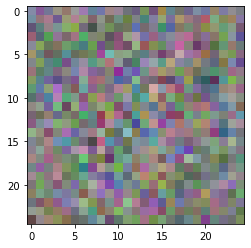

Step: 25
Generator adv: -0.214, rec: 0.086
Critic fake: 0.005 real: 0.514 grad: 1.245
Steps per second: 10.34


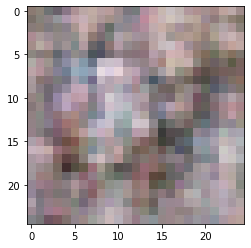

Step: 50
Generator adv: -0.198, rec: 0.081
Critic fake: 0.012 real: 0.573 grad: 1.413
Steps per second: 11.49


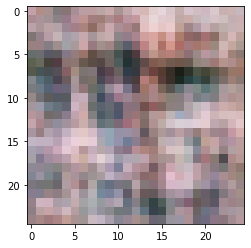

Step: 75
Generator adv: -0.061, rec: 0.076
Critic fake: 0.058 real: 0.707 grad: 2.343
Steps per second: 12.87


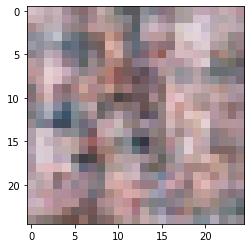

Step: 100
Generator adv: 0.222, rec: 0.075
Critic fake: 0.095 real: 0.761 grad: 2.924
Steps per second: 10.35


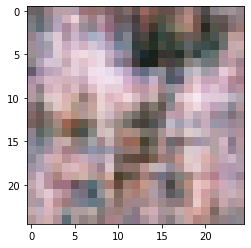

Step: 125
Generator adv: -0.118, rec: 0.075
Critic fake: 0.080 real: 0.870 grad: 1.095
Steps per second: 10.33


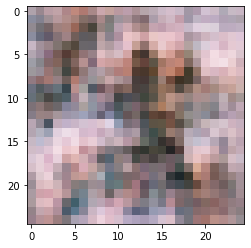

Step: 150
Generator adv: 0.062, rec: 0.075
Critic fake: 0.021 real: 0.774 grad: 3.523
Steps per second: 10.53


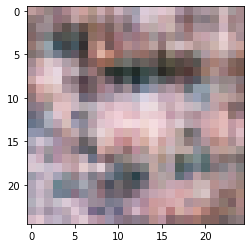

Step: 175
Generator adv: -0.057, rec: 0.072
Critic fake: -0.061 real: 0.828 grad: 1.371
Steps per second: 9.78


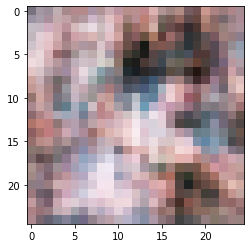

Step: 200
Generator adv: 0.134, rec: 0.073
Critic fake: 0.176 real: 0.807 grad: 2.924
Steps per second: 9.44


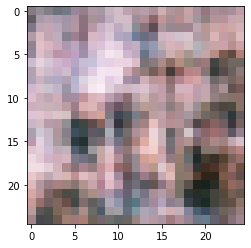

Step: 225
Generator adv: -0.006, rec: 0.074
Critic fake: -0.123 real: 0.881 grad: 2.277
Steps per second: 10.27


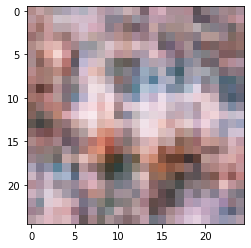

Step: 250
Generator adv: 0.079, rec: 0.073
Critic fake: 0.125 real: 0.865 grad: 1.701
Steps per second: 9.73


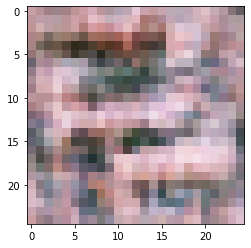

Step: 275
Generator adv: 0.148, rec: 0.070
Critic fake: 0.201 real: 0.879 grad: 1.881
Steps per second: 10.12


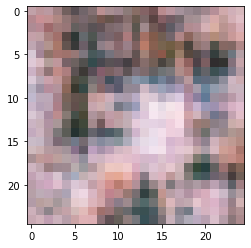

Step: 300
Generator adv: -0.144, rec: 0.073
Critic fake: 0.017 real: 0.825 grad: 1.439
Steps per second: 9.22


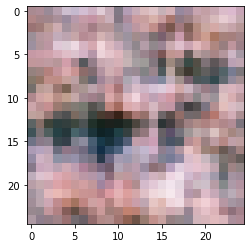

Step: 325
Generator adv: -0.001, rec: 0.075
Critic fake: -0.070 real: 0.824 grad: 1.452
Steps per second: 9.79


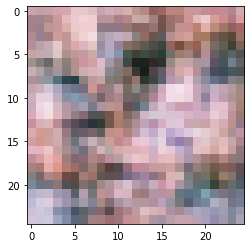

Step: 350
Generator adv: 0.148, rec: 0.072
Critic fake: 0.022 real: 0.873 grad: 2.192
Steps per second: 9.79


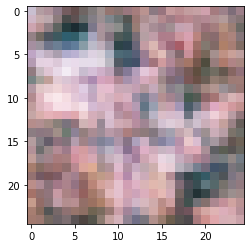

Step: 375
Generator adv: -0.075, rec: 0.072
Critic fake: -0.238 real: 0.902 grad: 2.674
Steps per second: 9.17


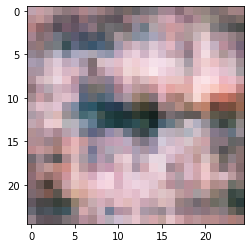

Step: 400
Generator adv: -0.162, rec: 0.071
Critic fake: 0.128 real: 0.853 grad: 3.188
Steps per second: 9.84


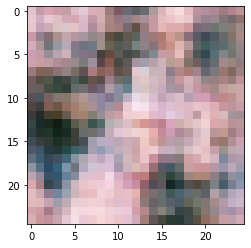

Step: 425
Generator adv: -0.241, rec: 0.070
Critic fake: -0.317 real: 1.014 grad: 5.649
Steps per second: 9.91


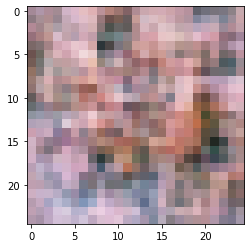

Step: 450
Generator adv: -0.086, rec: 0.070
Critic fake: 0.076 real: 0.988 grad: 2.802
Steps per second: 10.42


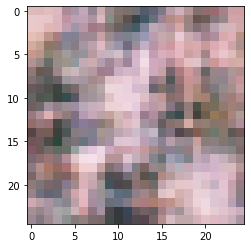

Step: 475
Generator adv: -0.030, rec: 0.072
Critic fake: 0.695 real: 1.211 grad: 1.914
Steps per second: 12.02


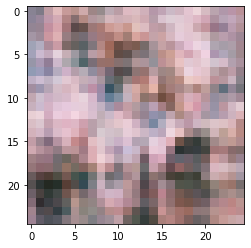

Step: 500
Generator adv: 0.249, rec: 0.072
Critic fake: 0.132 real: 0.983 grad: 4.614
Steps per second: 12.87


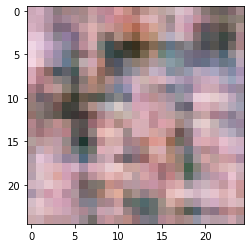

Step: 525
Generator adv: -0.058, rec: 0.071
Critic fake: -0.023 real: 0.941 grad: 1.416
Steps per second: 10.23


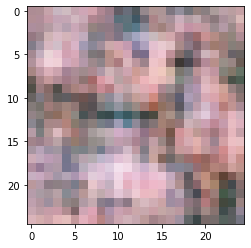

Step: 550
Generator adv: -0.035, rec: 0.069
Critic fake: -0.128 real: 1.007 grad: 3.393
Steps per second: 10.20


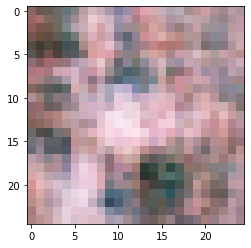

Step: 575
Generator adv: -0.253, rec: 0.068
Critic fake: -0.242 real: 1.056 grad: 3.400
Steps per second: 10.33


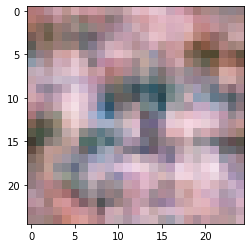

Step: 600
Generator adv: 0.109, rec: 0.068
Critic fake: -0.167 real: 1.060 grad: 3.252
Steps per second: 10.65


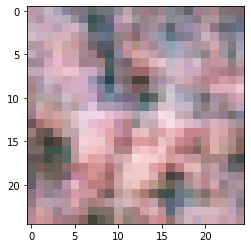

Step: 625
Generator adv: -0.182, rec: 0.068
Critic fake: 0.079 real: 1.003 grad: 2.665
Steps per second: 12.01


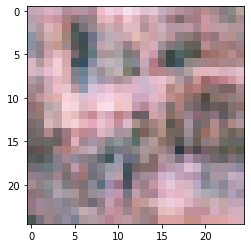

Step: 650
Generator adv: 0.205, rec: 0.068
Critic fake: -0.172 real: 1.132 grad: 2.518
Steps per second: 11.32


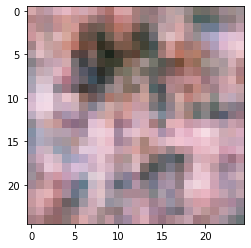

Step: 675
Generator adv: -0.052, rec: 0.069
Critic fake: 0.011 real: 1.074 grad: 4.020
Steps per second: 9.77


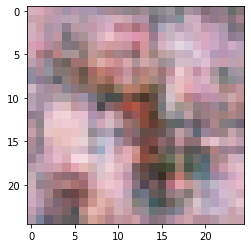

Step: 700
Generator adv: 0.231, rec: 0.069
Critic fake: 0.222 real: 1.149 grad: 3.597
Steps per second: 9.54


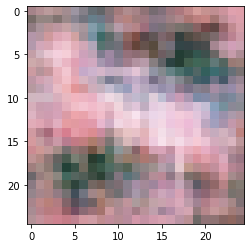

Step: 725
Generator adv: -0.458, rec: 0.068
Critic fake: -0.068 real: 1.093 grad: 3.252
Steps per second: 9.39


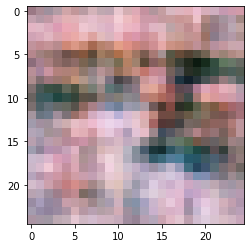

Step: 750
Generator adv: -0.029, rec: 0.068
Critic fake: -0.180 real: 1.114 grad: 2.916
Steps per second: 10.09


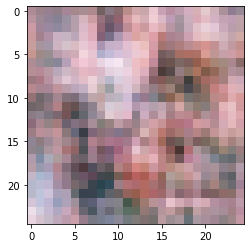

Step: 775
Generator adv: -0.230, rec: 0.068
Critic fake: -0.155 real: 1.173 grad: 4.285
Steps per second: 10.93


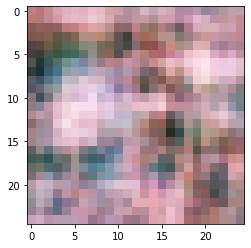

Step: 800
Generator adv: -0.096, rec: 0.068
Critic fake: -0.127 real: 1.125 grad: 3.879
Steps per second: 10.77


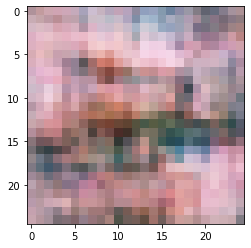

Step: 825
Generator adv: -0.277, rec: 0.068
Critic fake: 0.031 real: 1.100 grad: 2.471
Steps per second: 10.63


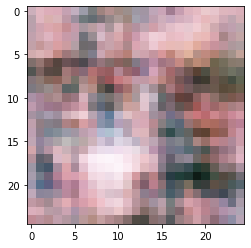

Step: 850
Generator adv: 0.048, rec: 0.068
Critic fake: -0.256 real: 1.096 grad: 4.086
Steps per second: 10.48


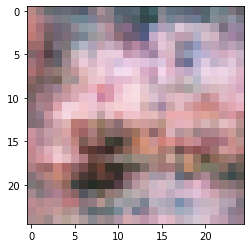

Step: 875
Generator adv: -0.349, rec: 0.068
Critic fake: 0.397 real: 1.153 grad: 3.260
Steps per second: 10.39


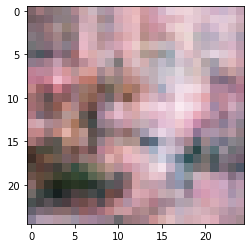

Step: 900
Generator adv: -0.364, rec: 0.068
Critic fake: 0.416 real: 1.197 grad: 3.371
Steps per second: 10.67


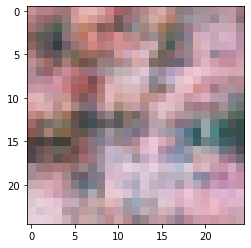

Step: 925
Generator adv: -0.053, rec: 0.069
Critic fake: 0.260 real: 1.239 grad: 4.654
Steps per second: 10.33


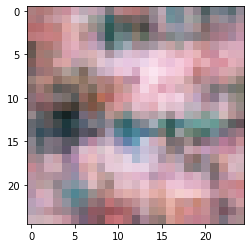

Step: 950
Generator adv: -0.185, rec: 0.068
Critic fake: 0.115 real: 1.278 grad: 4.438
Steps per second: 9.93


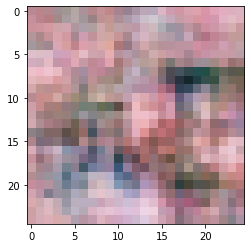

Step: 975
Generator adv: 0.119, rec: 0.068
Critic fake: -0.018 real: 1.203 grad: 4.336
Steps per second: 9.38


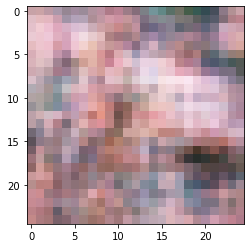

Step: 1000
Generator adv: -0.055, rec: 0.068
Critic fake: -0.003 real: 1.260 grad: 4.589
Steps per second: 9.44


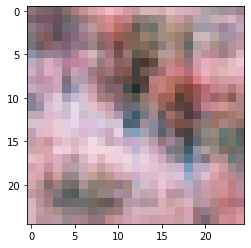

Step: 1025
Generator adv: -0.041, rec: 0.068
Critic fake: -0.055 real: 1.270 grad: 4.991
Steps per second: 9.15


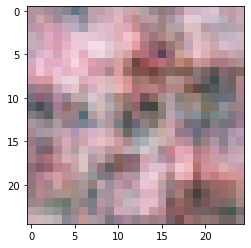

Step: 1050
Generator adv: 0.118, rec: 0.068
Critic fake: 0.258 real: 1.198 grad: 3.789
Steps per second: 9.18


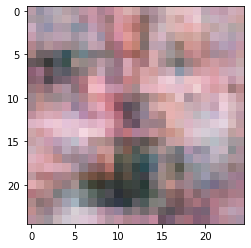

Step: 1075
Generator adv: -0.076, rec: 0.068
Critic fake: 0.034 real: 1.217 grad: 3.348
Steps per second: 9.83


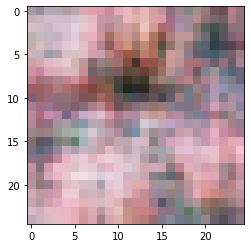

Step: 1100
Generator adv: -0.146, rec: 0.068
Critic fake: -0.015 real: 1.179 grad: 4.528
Steps per second: 10.24


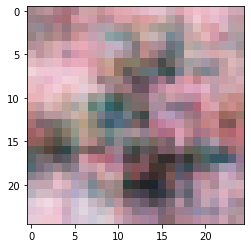

Step: 1125
Generator adv: 0.247, rec: 0.068
Critic fake: -0.016 real: 1.246 grad: 4.773
Steps per second: 10.28


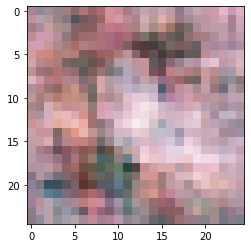

Step: 1150
Generator adv: -0.162, rec: 0.068
Critic fake: -0.137 real: 1.209 grad: 4.671
Steps per second: 11.08


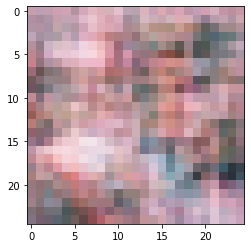

Step: 1175
Generator adv: 0.043, rec: 0.068
Critic fake: 0.294 real: 1.206 grad: 2.866
Steps per second: 10.59


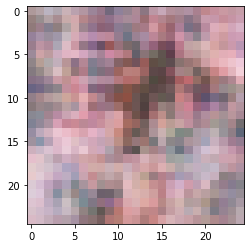

Step: 1200
Generator adv: 0.085, rec: 0.068
Critic fake: 0.004 real: 1.255 grad: 3.503
Steps per second: 11.73


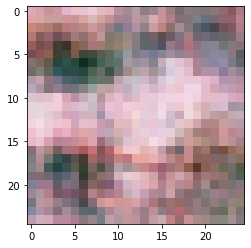

Step: 1225
Generator adv: -0.285, rec: 0.068
Critic fake: 0.045 real: 1.286 grad: 3.758
Steps per second: 10.11


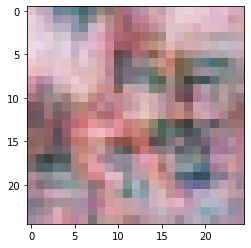

Step: 1250
Generator adv: -0.123, rec: 0.068
Critic fake: 0.032 real: 1.272 grad: 5.181
Steps per second: 10.83


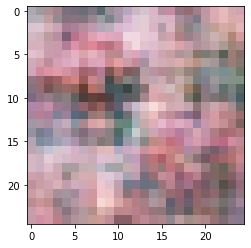

Step: 1275
Generator adv: 0.042, rec: 0.068
Critic fake: -0.245 real: 1.262 grad: 4.245
Steps per second: 10.43


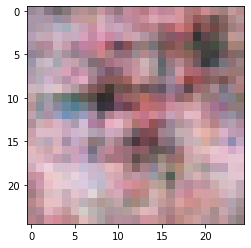

Step: 1300
Generator adv: -0.590, rec: 0.068
Critic fake: -0.208 real: 1.329 grad: 4.050
Steps per second: 11.95


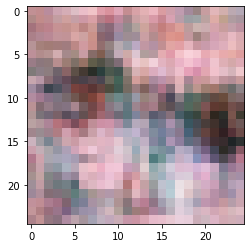

Step: 1325
Generator adv: -0.104, rec: 0.068
Critic fake: -0.087 real: 1.242 grad: 5.105
Steps per second: 10.55


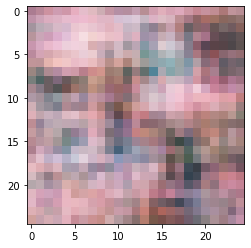

Step: 1350
Generator adv: -0.103, rec: 0.068
Critic fake: -0.270 real: 1.305 grad: 4.948
Steps per second: 10.58


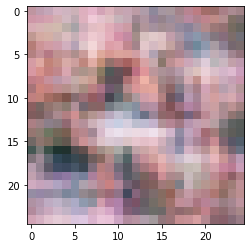

Step: 1375
Generator adv: 0.260, rec: 0.068
Critic fake: -0.371 real: 1.275 grad: 4.835
Steps per second: 12.76


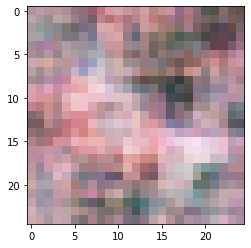

Step: 1400
Generator adv: -0.019, rec: 0.068
Critic fake: 0.265 real: 1.263 grad: 3.680
Steps per second: 11.36


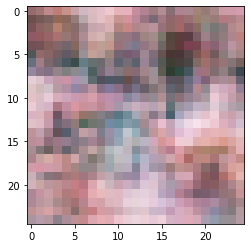

Step: 1425
Generator adv: -0.130, rec: 0.068
Critic fake: 0.366 real: 1.244 grad: 6.101
Steps per second: 10.48


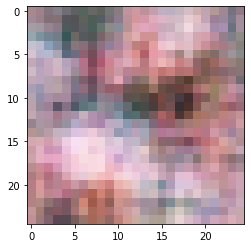

Step: 1450
Generator adv: -0.157, rec: 0.068
Critic fake: 0.130 real: 1.290 grad: 3.049
Steps per second: 11.29


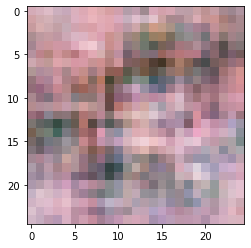

Step: 1475
Generator adv: -0.337, rec: 0.068
Critic fake: -0.165 real: 1.287 grad: 3.416
Steps per second: 10.91


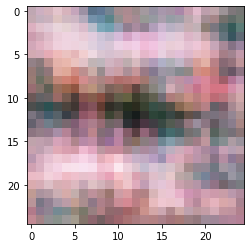

Step: 1500
Generator adv: 0.195, rec: 0.068
Critic fake: -0.030 real: 1.307 grad: 3.708
Steps per second: 10.68


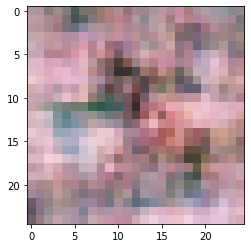

Step: 1525
Generator adv: 0.199, rec: 0.068
Critic fake: 0.025 real: 1.298 grad: 3.273
Steps per second: 11.03


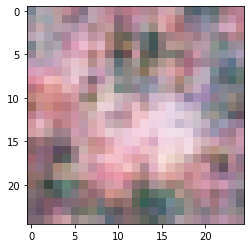

Step: 1550
Generator adv: 0.088, rec: 0.068
Critic fake: -0.072 real: 1.274 grad: 4.292
Steps per second: 10.41


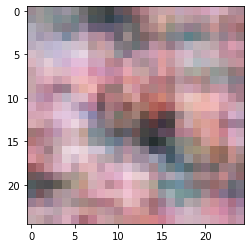

Step: 1575
Generator adv: 0.021, rec: 0.068
Critic fake: -0.139 real: 1.296 grad: 3.390
Steps per second: 10.28


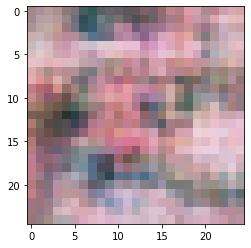

Step: 1600
Generator adv: -0.266, rec: 0.068
Critic fake: -0.171 real: 1.332 grad: 3.494
Steps per second: 10.54


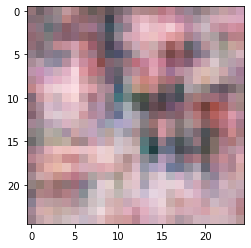

Step: 1625
Generator adv: 0.086, rec: 0.068
Critic fake: -0.207 real: 1.309 grad: 3.618
Steps per second: 10.55


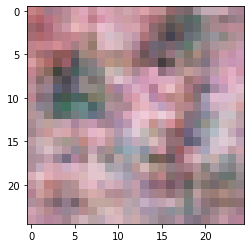

Step: 1650
Generator adv: -0.496, rec: 0.068
Critic fake: 0.195 real: 1.294 grad: 6.869
Steps per second: 11.08


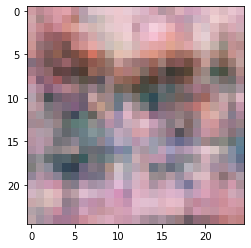

Step: 1675
Generator adv: -0.092, rec: 0.068
Critic fake: -0.104 real: 1.290 grad: 3.473
Steps per second: 10.56


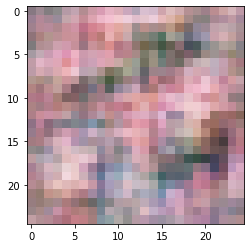

Step: 1700
Generator adv: -0.009, rec: 0.068
Critic fake: 0.163 real: 1.297 grad: 3.643
Steps per second: 10.66


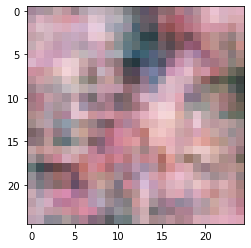

Step: 1725
Generator adv: 0.205, rec: 0.068
Critic fake: -0.162 real: 1.287 grad: 3.886
Steps per second: 10.35


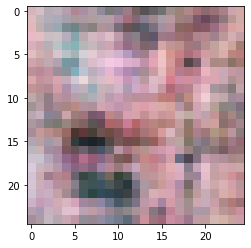

Step: 1750
Generator adv: -0.111, rec: 0.068
Critic fake: 0.054 real: 1.287 grad: 5.355
Steps per second: 11.81


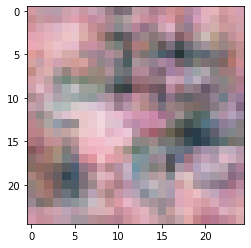

Step: 1775
Generator adv: 0.386, rec: 0.068
Critic fake: -0.068 real: 1.289 grad: 3.533
Steps per second: 10.90


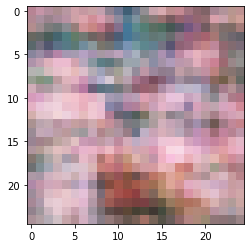

Step: 1800
Generator adv: 0.238, rec: 0.068
Critic fake: 0.282 real: 1.291 grad: 6.128
Steps per second: 11.01


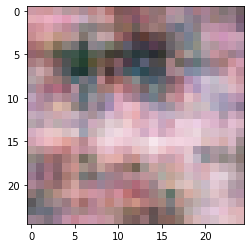

Step: 1825
Generator adv: -0.029, rec: 0.068
Critic fake: -0.130 real: 1.289 grad: 3.702
Steps per second: 12.09


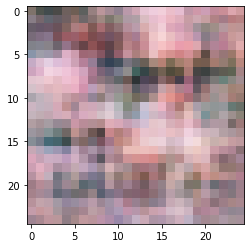

Step: 1850
Generator adv: 0.036, rec: 0.068
Critic fake: -0.186 real: 1.294 grad: 4.764
Steps per second: 10.61


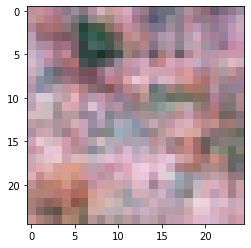

Step: 1875
Generator adv: 0.023, rec: 0.068
Critic fake: 0.071 real: 1.280 grad: 3.065
Steps per second: 10.45


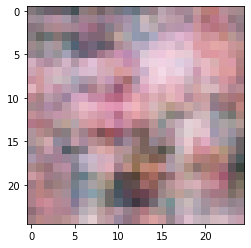

Step: 1900
Generator adv: 0.165, rec: 0.068
Critic fake: -0.051 real: 1.278 grad: 5.660
Steps per second: 10.64


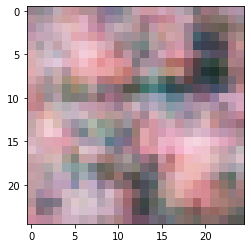

Step: 1925
Generator adv: -0.181, rec: 0.068
Critic fake: 0.010 real: 1.282 grad: 3.932
Steps per second: 11.48


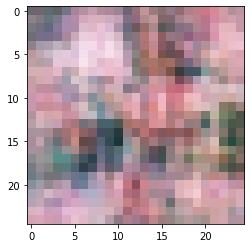

Step: 1950
Generator adv: 0.095, rec: 0.068
Critic fake: 0.153 real: 1.281 grad: 2.894
Steps per second: 10.02


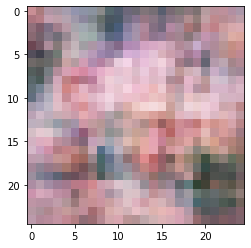

Step: 1975
Generator adv: 0.146, rec: 0.068
Critic fake: -0.117 real: 1.284 grad: 4.538
Steps per second: 10.60


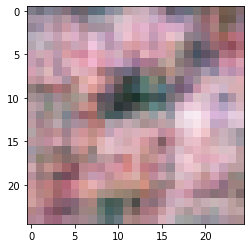

Reconstruction:


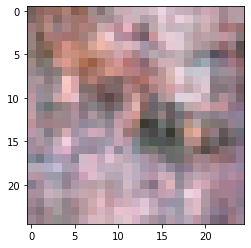

In [6]:
# seed stuff
np.random.seed(SEED)
torch.manual_seed(SEED)

# create the scaled images
original_image = np_image_to_normed_tensor(orig_img_uint).to(DEVICE)
scaled_original_images, exact_scale_sizes = create_scale_pyramid(original_image, 1/SCALING_FACTOR, NUM_SCALES)
scaled_original_images, exact_scale_sizes = scaled_original_images[::-1], exact_scale_sizes[::-1]  # reverse since we start from coarsest

# initialize the constant noise used in reconstruction
z_rec_coarsest = FIRST_SCALE_NOISE_STD * torch.randn_like(original_img_scales[0], device=DEVICE)
z_rec = [z_rec_coarsest] # a zero tensor is appended after each scale

# constant zero input for the coarsest scale during training
generator_zero_input = torch.zeros_like(z_rec_coarsest)

# loop values
kernel_count = INITIAL_KERNEL_COUNT
generator = None
generators, critics, noise_samplers = [], [], []
gen_losses, crit_losses = [], []
rmse = 1 # initial noise multiplier
for scale_index in range(NUM_SCALES):
  print('****************************\nScale {}'.format(scale_index))

  # get the original image at the necessary scale for reconstruction
  scaled_orig_img = original_img_scales[scale_index]

  if generator is not None:
    reconstruction = generator(generator_zero_input, z_rec)
    # calculate the RMSE to use for scaling the input in the next step
    scaled_reconstruction = F.interpolate(reconstruction, size=scale_sizes[scale_index], mode='bicubic')
    rmse = F.mse_loss(scaled_reconstruction, orig_img).item()

  # create the noise sampler based on the RMSE
  # BUG: same noise_sampler is used for every scale, oof!
  noise_std = FIRST_SCALE_NOISE_STD if scale_index == 0 else rmse * NOISE_BASE_STD
  noise_sampler = lambda x: sample_noise_like(x, mean=0.0, stdev=noise_std, device=DEVICE)
  print('RMSE: {:.2f}'.format(rmse))

  ## initialize the generator
  # increase kernel count if necessary
  kernel_count_changed = False
  if scale_index != 0 and scale_index % INCREASE_KERNEL_COUNT_EVERY == 0:
    kernel_count *= 2
    kernel_count_changed = True
  # create a generator for this specific scale
  scale_generator = SGNet(output_channels=3, kernel_count=kernel_count, final_activation=nn.Tanh(), conv_init=conv2d_initializer, bn_init=batch_norm_initializer).to(DEVICE)
  # if possible, initialize with weights from the lower layer
  if scale_index != 0 and not kernel_count_changed:
    prev_generator = generators[-1]
    prev_gen_weights = prev_generator.state_dict()
    scale_generator.load_state_dict(prev_gen_weights)
  # set train mode & add to generator list
  scale_generator.train()
  generators.append(scale_generator)
  # create a single generator view
  generator = MultiScaleSGNetView(generators, scale_sizes, noise_sampler)

  ## initialize the critic (discriminator)
  # the authors recommend initializing the discriminator using the weights of
  # the previous one, which means that we do not need to actually re-create 
  # unless the number of kernels is being changed
  if scale_index % INCREASE_KERNEL_COUNT_EVERY == 0:
    critic = SGNet(output_channels=1, kernel_count=kernel_count, final_activation=None, conv_init=conv2d_initializer, bn_init=batch_norm_initializer).to(DEVICE) # patch critic

  # weight of gen0 to ensure it is not trained
  print('Norm sums:')
  for i, gen in enumerate(generators):
    wbs = get_weights_and_biases(gen)
    norm = torch.tensor([torch.norm(x) for x in wbs]).sum().item()
    print('Gen-{} norm: {:.2f}'.format(i, norm))
  print('Critic norm: {:.2f}'.format(torch.tensor([torch.norm(x) for x in get_weights_and_biases(critic)]).sum().item()))

  # re-create the optimizers and schedulers
  gen_optimizer = torch.optim.Adam(generator.parameters(), LEARNING_RATE, (BETA_1, BETA_2))
  gen_sched = torch.optim.lr_scheduler.StepLR(gen_optimizer, LR_DROP_STEP, LR_DROP_MULT)

  dis_optimizer = torch.optim.Adam(critic.parameters(), LEARNING_RATE, (BETA_1, BETA_2))
  dis_sched = torch.optim.lr_scheduler.StepLR(dis_optimizer, LR_DROP_STEP, LR_DROP_MULT)

  if scale_index != 0:
    z_rec.append(torch.zeros_like(orig_img))
  print(orig_img.shape)

  for step in range(NUM_ITERS):

    # real 1, fake 0

    for _ in range(DIS_STEP_PER_ITER):
      dis_optimizer.zero_grad()

      fake_imgc = generator(generator_zero_input)
      epsilon = np.random.uniform(0, 1)

      # adversarial loss
      # take a sample from the line between the real and generated images
      # for use in the gradient penalty (Impr. Training of WGANs)

      # another thing that is not very clear is the WGAN-GP loss in this context.
      # In the case of a scalar discr. output, what should be done is simply
      # norm the gradient (image-shaped) across the channel axis, and take 
      # the mean across all pixels.
      # In this case, the output of the critic (discr) is an image (PatchGAN).
      # If we take its mean to obtain a scalar and then apply the same approach
      # as the scalar output discr., it seems to supress the penalty twice 
      # (as if the mean was applied twice). Instead, taking the sum of the
      # output allows us to apply the mean only once, which we believe is the
      # proper normalization.

      grad_sample = epsilon * orig_img + (1 - epsilon) * fake_imgc
      f_grad_sample = critic(grad_sample).sum()
      grad, = torch.autograd.grad(f_grad_sample, grad_sample, create_graph=True, retain_graph=True)

      # flat_grad = torch.flatten(flat_grad, start_dim=1) # (N, C, H, W) -> (N, C*H*W)
      # grad_loss = ((torch.norm(grad, p=2, dim=1) - 1)**2).mean() # mean over batch

      # for now though, use the same loss as the authors since it works
      grad_loss = ((torch.norm(grad, 2, dim=1) - 1)**2).mean() # mean over batch

      fake_loss = critic(fake_imgc).mean()
      real_loss = critic(orig_img).mean()
      dis_loss =  fake_loss - real_loss + GP_WEIGHT * grad_loss # TODO: are signs of fake and real loss correct? 
      dis_loss.backward()
      dis_optimizer.step()
      dis_sched.step()
      crit_losses.append(dis_loss.item())

    for _ in range(GEN_STEP_PER_ITER):
      gen_optimizer.zero_grad()

      # always provide zero input to the coarsest scale
      # the model handles noise sampling on its own
      fake_img = generator(generator_zero_input)

      # adversarial loss
      adv_loss = -critic(fake_img).mean()

      # reconstruction loss
      rec_img = generator(generator_zero_input, z_rec)
      # the representation space of the images is not clear in the paper.
      # since the reconstruction loss seemed very low to us in the [-1, 1]
      # range, we decided to calculate it in the [0, 255] range instead
      # EDIT: after checking out their own code, it seems that there is
      # no multiplier. however, the reconstruction loss remains too small?
      rec_loss = F.mse_loss(orig_img, rec_img)

      gen_loss = adv_loss + REC_ALPHA * rec_loss
      gen_loss.backward()
      gen_optimizer.step()
      gen_sched.step()
      gen_losses.append(gen_loss.item())

    if step % PRINT_EVERY == 0:
      print('Step: {}'.format(step))
      print('Generator adv: {:.3f}, rec: {:.3f}'.format(adv_loss.item(), rec_loss.item()))
      print('Critic fake: {:.3f} real: {:.3f} grad: {:.3f}'.format(fake_loss.item(), real_loss.item(), grad_loss.item()))
      if step != 0:
        elapsed = time() - last_print
        print('Steps per second: {:.2f}'.format(PRINT_EVERY / elapsed))
      plt.imshow(net2img(fake_img))
      plt.show()
      last_print = time()

  print('Reconstruction:')
  plt.imshow(net2img(generator(generator_zero_input, z_rec)))
  plt.show()


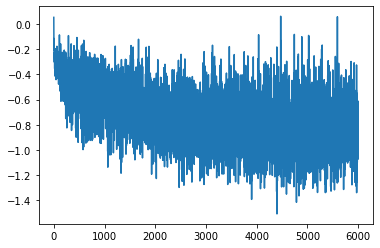

In [14]:
plt.plot(crit_losses)
plt.show()

In [15]:
!nvidia-smi

Mon May 18 16:59:29 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    33W / 250W |    719MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [16]:
print(SGNet(output_channels=1, kernel_count=kernel_count, final_activation=nn.Identity()).to(DEVICE)(torch.ones(1, 3, 5, 5).cuda()))

tensor([[[[ 0.3255,  0.1632,  1.0725,  0.8181,  0.0989],
          [ 0.6618,  0.0165,  0.5550,  0.5524,  0.1002],
          [-0.0705, -0.8659, -0.0857,  0.4745,  0.4221],
          [ 0.4590, -0.0800,  0.1563,  0.5252,  0.3780],
          [ 0.5193,  0.1316,  0.2902,  0.5200,  0.5651]]]], device='cuda:0',
       grad_fn=<AddBackward0>)
